### <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 3 - Parte 1  </H3>
<hr style="height:2px;border:none"/>

**Integrantes**  
* Rodrigo Hermosilla
* Eliana Providel
* Sebastián Rodriguez

<a id="primero"></a>
## 1. Regresión para ubicación espacial

>Un problema que tiene aplicaciones para muchos servicios es el calculo de la ubicación espacial exacta de un dispositivo conectado dentro de un edificio o un complejo de edificios. Estando dentro de un aeropuerto nuestro celular nos podría dar indicaciones para llegar a nuestra puerta de embarque o dentro de un mall encontrar la tienda que encontramos serían aplicaciones que fácilmente se desprenden de la solución a este problema. Actualmente en exteriores el problema se soluciona fácilmente mediante el uso de GPS, sin embargo en interiores el problema se vuelve más complicado pues hay considerable pérdida de la señar GPS y muchas superficies de construcción pueden resultar reflectantes para algunos tipos de señales por lo cual el problema es mucho más dificil de modelar que el problema en el exterior. 


>En esta primera parte de la tarea utilizaremos un _dataset_ creado en 2013 con más de 20000 mediciones de posición dentro de 4 edificios de la universidad de Jaume, disponible en https://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc junto con una detallada descripción. Nuestra tarea será predecir la ubicación espacial en latitud, longitud, y altura (en pisos) de los distintos usuarios que realizaron esta tarea, a partir de las intensidades de señal medidas por los 520 distintos puntos de acceso inalambricos. Para esto, probaremos utilizaremos arboles de regresión, regresión lineal y redes neuronales, comparando los distintos desempeños y las ventajas y desventajas de cada aproximación. 


In [1]:
from sklearn.utils import check_random_state
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt 
import seaborn as sns, numpy as np
import pandas as pd
from sklearn.utils import shuffle
import time
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

sns.set();

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/home/srodriguez/miniconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

Using TensorFlow backend.


## Acerca del data set

**Descripción de los atributos:**
- *WAP001*          : Valor de intensidad para WAP001. Valores enteros negativo de -104 a 0 y +100. Valor positivo 100 usado si WAP001 no fue detectado.
...
- *WAP520*          : Valor de intensidad para WAP520. Valores negativos en rango desde -104 hasta 0, y +100. Valor positivo Vvalue 100 se usa si WAP520 no es detectado.
- *Longitude*       : Longitud. Valores reales negativos desde -7695.9387549299299000 hasta -7299.786516730871000
- *Latitude*        : Latitud. Valores reales positivos desde 4864745.7450159714 hasta 4865017.3646842018.
- *Floor*           :  Altitud en pisos al interior del edficio. Valores enteros desde 0 hasta 4.
- *BuildingID*      : Identificador del edificio. La medidas se tomaron en tres edificios distintos. Valores enteros categóricos desde 0 hasta 2.
- *SpaceID*         : Número identificador interno para identificar el Espacio (oficina, corredor, sala de clases) donde se tomó la captura. Valores enteros categóricos.
- *RelativePosition*: Posición relativa respecto al Espacio (1 - Adentro, 2- Afuera frente a la puerta). Valores enteros categóricos.
- *UserID*          : Identificador de usuario (18 valores). Valores enteros categóricos.
- *PhoneID*         : Identificador de dispositivo Android. Valores enteros categóricos.
- *Timestamp*       : Tiempo UNIX cuando la captura fue tomada. Valor entero.


*PhoneID*
- 0 Celkon A27 4.0.4(6577) 0 
- 1 GT-I8160 2.3.6 8 
- 2 GT-I8160 4.1.2 0 
- 3 GT-I9100 4.0.4 5 
- 4 GT-I9300 4.1.2 0 
- 5 GT-I9505 4.2.2 0 
- 6 GT-S5360 2.3.6 7 
- 7 GT-S6500 2.3.6 14 
- 8 Galaxy Nexus 4.2.2 10 
- 9 Galaxy Nexus 4.3 0 
- 10 HTC Desire HD 2.3.5 18 
- 11 HTC One 4.1.2 15 
- 12 HTC One 4.2.2 0 
- 13 HTC Wildfire S 2.3.5 0,11 
- 14 LT22i 4.0.4 0,1,9,16 
- 15 LT22i 4.1.2 0 
- 16 LT26i 4.0.4 3 
- 17 M1005D 4.0.4 13 
- 18 MT11i 2.3.4 4 
- 19 Nexus 4 4.2.2 6 
- 20 Nexus 4 4.3 0 
- 21 Nexus S 4.1.2 0 
- 22 Orange Monte Carlo 2.3.5 17 
- 23 Transformer TF101 4.0.3 2 
- 24 bq Curie 4.1.1 12 

**Total de atributos:** 529

**Descripción del dataset**: .

- El dataset tiene datos de tres edificios de la Universitat Jaume I con 4 o más pisos y casi 110.000m2. 
- Tareas: clasificación, por ejemplo, identificación real de edificios y pisos, o regresión, por ejemplo, Estimación de longitud y latitud reales.
- Creado en 2013,  con apoyo de más de 20 usuarios diferentes y 25 dispositivos Android. 
- Tamaño dataset: 19937 registros de entrenamiento (archivo trainingData.csv) y 1111 registros de validación (archivo validationData.csv).

**Objetivo**:

Tarea de predicción, utilizando  datos que permiten la localización de usuario al interior de edificios, en base al target 'LONGITUDE', 'LATITUDE' y 'FLOOR'

#### 1.a Carga de datos

>Cargue los datos de entrenamiento y validación y júntelos en un solo DataFrame como muestra el código. 

>De los datos entregados luego del _target_ solo consideraremos el tipo de celular utilizado, convirtiendolo a variables _dummies_ como muestra el código. 

>Separe el _target_ del resto de los datos.

In [3]:
df_tr = pd.read_csv("UJIndoorLoc/trainingData.csv")
df_val = pd.read_csv("UJIndoorLoc/validationData.csv")

print("size from file, train: ", df_tr.shape )
print("size from file, val  : ", df_val.shape )

df = shuffle(df_tr.append(df_val)) ##Shuffle arrays or sparse matrices in a consistent way

size from file, train:  (19937, 529)
size from file, val  :  (1111, 529)


In [4]:
## conociendo los datos
df.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
3555,100,100,100,100,100,-79,100,100,100,100,...,100,-7410.692300,4.864890e+06,0,1,243,2,7,6,1371715720
302,100,100,100,100,100,100,100,100,100,100,...,100,-7524.486762,4.864934e+06,1,1,0,0,0,13,1380177775
223,100,100,100,100,100,100,100,100,100,100,...,100,-7595.974000,4.864981e+06,1,0,0,0,0,0,1379668002
1948,100,100,100,100,100,100,100,100,100,100,...,100,-7356.612000,4.864840e+06,3,2,109,2,5,3,1371721028
16328,100,100,100,100,100,100,100,100,100,100,...,100,-7641.624600,4.865009e+06,0,0,130,2,1,14,1371036607


In [5]:
df.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,...,21048.000000,21048.000000,2.104800e+04,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,21048.000000,2.104800e+04
mean,99.760500,99.830388,99.982326,99.982326,99.634122,97.281927,95.011640,93.845401,94.480758,99.145192,...,99.991733,-7467.702771,4.864873e+06,1.669137,1.188854,140.595211,1.736269,8.589367,12.963892,1.371906e+09
std,6.811116,5.643191,1.813086,1.813165,8.385624,22.327658,29.747638,32.964914,30.897265,12.765499,...,1.199344,124.084870,6.746981e+01,1.212608,0.838402,65.770099,0.547503,5.261661,5.437353,2.126924e+06
min,-97.000000,-90.000000,-87.000000,-88.000000,-97.000000,-98.000000,-99.000000,-99.000000,-98.000000,-99.000000,...,-74.000000,-7695.938755,4.864746e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.369909e+09
25%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,-7601.616200,4.864821e+06,1.000000,0.000000,108.000000,2.000000,4.000000,8.000000,1.371709e+09
50%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,-7425.661100,4.864854e+06,2.000000,1.000000,127.000000,2.000000,10.000000,13.000000,1.371716e+09
75%,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,-7359.331100,4.864930e+06,3.000000,2.000000,206.000000,2.000000,12.000000,14.000000,1.371721e+09
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,-7299.786517,4.865017e+06,4.000000,2.000000,254.000000,2.000000,18.000000,24.000000,1.381248e+09


In [6]:
df.columns

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP'],
      dtype='object', length=529)

In [7]:
df.shape

(21048, 529)

In [8]:
## obteniendo el target
target_col =  df.columns[[520,521,522]] 
target_col

Index(['LONGITUDE', 'LATITUDE', 'FLOOR'], dtype='object')

In [9]:
## obteniendo los atributos
attribute_col = df.columns[0:520]
attribute_col

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP511', 'WAP512', 'WAP513', 'WAP514', 'WAP515', 'WAP516', 'WAP517',
       'WAP518', 'WAP519', 'WAP520'],
      dtype='object', length=520)

In [10]:
x_un = pd.get_dummies(df.PHONEID)
categorical_columns = x_un.columns
x_un[attribute_col] = df[attribute_col]
x_un.head()

,0,1,2,3,4,5,6,7,8,9,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
3555,0,0,0,0,0,0,1,0,0,0,...,100,100,100,100,100,100,100,100,100,100
302,0,0,0,0,0,0,0,0,0,0,...,100,100,100,100,100,100,100,100,100,100
223,1,0,0,0,0,0,0,0,0,0,...,100,100,100,100,100,100,100,100,100,100
1948,0,0,0,1,0,0,0,0,0,0,...,100,100,100,100,100,100,-66,100,100,100
16328,0,0,0,0,0,0,0,0,0,0,...,100,100,100,100,100,100,100,100,100,100


In [11]:
y_u = df[target_col]
y_u.head()

,LONGITUDE,LATITUDE,FLOOR
3555,-7410.692300,4.864890e+06,0
302,-7524.486762,4.864934e+06,1
223,-7595.974000,4.864981e+06,1
1948,-7356.612000,4.864840e+06,3
16328,-7641.624600,4.865009e+06,0


>Separe los datos a partir de su índice, dejando un 80% de datos en el _train set_ y un 20% de validación. 
¿Por qué no es mala idea en este caso separar los datos a partir de su índice? ¿Qué problema podría tenerse en caso de no haber hecho `shuffle` al momento de cargar los datos? 


In [12]:
#Separando los datos, 80% train y 20% val
x_tr_un = x_un.iloc[0:16838]
x_val_un = x_un.iloc[16839:21048]

y_tr_un = y_u.iloc[0:16838]
y_val_un = y_u.iloc[16839:21048]

In [13]:
print("x_train: ", x_tr_un.shape)
print("x_val : ", x_val_un.shape)
print("y_train: ", y_tr_un.shape)
print("y_val : ", y_val_un.shape)

x_train:  (16838, 545)
x_val :  (4209, 545)
y_train:  (16838, 3)
y_val :  (4209, 3)


**¿Por qué no es mala idea en este caso separar los datos a partir de su índice?** 

Inicialmente los datos venían en dos archivos separados, train y validación, que fueron mezclados en un dataset utilizando `shuffle`, por lo que utilizar el índice no tiene problema dada la mezcla que tienen los datos. En caso que los datos sólo se hubiesen unidos esto no hubiese sido una buena idea.

**¿Qué problema podría tenerse en caso de no haber hecho shuffle al momento de cargar los datos?**

Tendría el problema que todos los datos en *x_tr* vendrían del archivo *trainingData*, y que el conjunto de datos *x_val* estaría compuesto por un conjunto de datos del archivo *trainingData* (los ultimos) y por todos los datos del archivo *validationData*.


#### 1.b Estandarización de los datos

>Utilice _Standar Scaler_ para los atributos no categóricos y para los datos categóricos simplemente sustraiga 0.5, como muestra el código. ¿Tiene realmente sentido estandarizar los datos categóricos (binarios) o le parece mejor la aproximación elegida?

>Estandarice igualmente el _target_. Cabe mencionar que la tercera componente del target es el piso en el que se encuentra, variable categórica, preferiremos utilizarla como variable continua para ver que tan bien nuestros algoritmos pueden aproximar la ubicación y para facilitar la comparación de distintos modelos. 

In [14]:
print(attribute_col.format)
print(categorical_columns.format)

<bound method Index.format of Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP511', 'WAP512', 'WAP513', 'WAP514', 'WAP515', 'WAP516', 'WAP517',
       'WAP518', 'WAP519', 'WAP520'],
      dtype='object', length=520)>
<bound method Index.format of Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24],
           dtype='int64')>


In [15]:
print(x_tr_un.shape)
print(y_tr_un.shape)

(16838, 545)
(16838, 3)


In [16]:
# Standar Scale para x_train y x_val
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()
x_tr = pd.np.concatenate((scaler_x.fit_transform(x_tr_un[attribute_col]), x_tr_un[categorical_columns].values-0.5), axis=1)
x_val = pd.np.concatenate((scaler_x.fit_transform(x_val_un[attribute_col]), x_val_un[categorical_columns].values-0.5), axis=1)

**¿Tiene realmente sentido estandarizar los datos categóricos (binarios) o le parece mejor la aproximación elegida?**

Basicamente, lo que se esta realizando es centrar estos datos categoricos en cero, dejando estas variables en valores entre  $\{-0.5,0.5\}$. Esta manera es mucho mas sencilla que la estandarización, los cuales le restan el promedio ($\mu$) para realizar el centrado y le dividen la desv estandard ($\sigma$) para normalizar. En este caso, los datos ya van estar normalizados si los dejamos entre $\{-0.5,0.5\}$, y solo resta centrarlos, por lo que la aproximación elegida nos parece mejor debido a que es mas facil de computar. 



In [17]:
#los datos antes de escalar
print(y_tr_un[:5])
print(y_val_un[:5])

         LONGITUDE      LATITUDE  FLOOR
3555  -7410.692300  4.864890e+06      0
302   -7524.486762  4.864934e+06      1
223   -7595.974000  4.864981e+06      1
1948  -7356.612000  4.864840e+06      3
16328 -7641.624600  4.865009e+06      0
       LONGITUDE      LATITUDE  FLOOR
9746  -7363.2823  4.864844e+06      2
6349  -7364.8389  4.864845e+06      0
18096 -7684.2981  4.864932e+06      2
2665  -7405.1009  4.864790e+06      3
867   -7488.8090  4.864901e+06      2


In [18]:
# Standar Scale para y_train y y_val
# Aca realizamos la estandarizacion con los datos a modo de variable continua
scaler_y = StandardScaler()
y_tr = scaler_y.fit_transform(y_tr_un[target_col])
y_val = scaler_y.fit_transform(y_val_un[target_col])

In [19]:
#datos escalados
print(y_tr)
print(y_val)

[[ 0.46058278  0.25636076 -1.37297176]
 [-0.45582049  0.90631494 -0.54926697]
 [-1.03151755  1.60708817 -0.54926697]
 ...
 [-0.47930215  0.83710171 -0.54926697]
 [-1.39677437  0.70956421  0.27443781]
 [-0.24298642 -0.2397451  -1.37297176]]
[[ 0.83799426 -0.41085733  0.26655311]
 [ 0.82540809 -0.39803356 -1.39064339]
 [-1.75763759  0.89293972  0.26655311]
 ...
 [-1.68223213  0.93263922  1.09515135]
 [ 0.80422441 -0.44409222 -0.56204514]
 [-1.57308512  0.93052147  1.09515135]]


#### 1.c Primer Arbol
>Entrenaremos ahora un árbol de regresión con produndidad 3. Como métrica utilizaremos el Error Absoluto Medio o MAE a lo largo del resto de esta pregunta. ¿Qué tan bueno le parece el _score_ (coeficiente $R^2$) obtenido por el regresor?

>Compare el desempeño del árbol, tanto en MAE como en _score_, en validación y entrenamiento, con respecto a un regresor lineal tradicional. ¿Cómo se comparan los tiempos de entrenamiento? ¿Le parece justificado el costo adicional?

In [20]:
#Para almacenar los resultados y utilizar en los gráficos
time_all  = {}
score_all = {}
mae_all   = {}

In [21]:
tree = DecisionTreeRegressor(criterion='mae', max_depth=3, random_state=42)

start_time = time.time()
tree.fit(x_tr, y_tr)
end_time = time.time()

time_tree = end_time - start_time
time_all["tree_3"] = time_tree

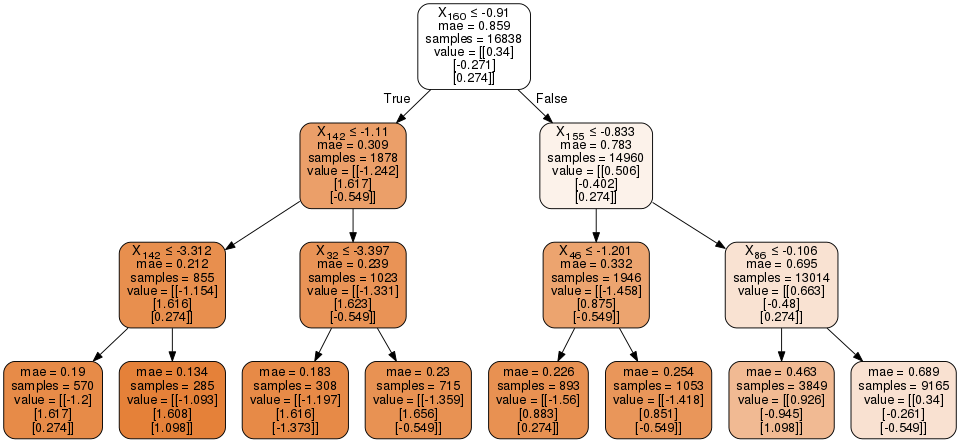

In [22]:
dot_data = StringIO()
export_graphviz(tree, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph .set_size('"10,10!"')
Image(graph.create_png())

In [23]:
print("training time: ", time_tree, "seg")

training time:  55.19698977470398 seg


In [24]:
#predict Validation
y_pred_val = tree.predict(x_val)
mae_tree_val = mean_absolute_error(scaler_y.inverse_transform(y_val), scaler_y.inverse_transform(y_pred_val))

#predict train
y_pred_tr = tree.predict(x_tr)
mae_tree_tr = mean_absolute_error(scaler_y.inverse_transform(y_tr), scaler_y.inverse_transform(y_pred_tr))

print("Mean Absolute Error, val: ", mae_tree_val)
print("Mean Absolute Error, train: ", mae_tree_tr)

mae_all["tree_3_tr"]    = mae_tree_tr
mae_all["tree_3_val"] = mae_tree_val

Mean Absolute Error, val:  28.051089531860928
Mean Absolute Error, train:  28.19597736385271


In [25]:
#calculo de score para train y val
#sklearn.metrics.r2_score(y_true, y_pred, sample_weight=None, multioutput=’uniform_average’)[source]

score_tr_tree = tree.score(x_tr, y_tr)
score_val_tree = tree.score(x_val, y_val)

print("Score train     : ", score_tr_tree)
print("Score validation: ", score_val_tree)

score_all["tree_3_tr"]  = score_tr_tree
score_all["tree_3_val"] = score_val_tree

Score train     :  0.4373052021933977
Score validation:  0.43769033230157756


In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
%%time
lr = LinearRegression()
lr.fit(x_tr, y_tr)


CPU times: user 1.88 s, sys: 132 ms, total: 2.02 s
Wall time: 217 ms


In [28]:
#predict Validation
y_pred_val = lr.predict(x_val)
mae_lr_val = mean_absolute_error(scaler_y.inverse_transform(y_val), scaler_y.inverse_transform(y_pred_val))

#predict train
y_pred_tr = lr.predict(x_tr)
mae_lr_tr = mean_absolute_error(scaler_y.inverse_transform(y_tr), scaler_y.inverse_transform(y_pred_tr))

print("Mean Absolute Error, val: ", mae_lr_val)
print("Mean Absolute Error, train: ", mae_lr_tr)

mae_all["lr_tr"]    = mae_lr_tr
mae_all["lr_val"] = mae_lr_val

score_tr_lr = lr.score(x_tr, y_tr)
score_val_lr = lr.score(x_val, y_val)

print("Score train     : ", score_tr_lr)
print("Score validation: ", score_val_lr)

score_all["lr_tr"]  = score_tr_lr
score_all["lr_val"] = score_val_lr

Mean Absolute Error, val:  3159916633373.7886
Mean Absolute Error, train:  11.514584079593982
Score train     :  0.9245886488417722
Score validation:  -1.2560439950721512e+24


**¿Cómo se comparan los tiempos de entrenamiento? ¿Le parece justificado el costo adicional?**

Según los resultados que hemos obtenido, este costo adicional de lo que conlleva entrenar un arbol de decisión con maxima profundidad de 3, si es justificado, demorandose 55.197 segundos. Esto debido a que cuando comparamos con la regresión lineal, que es casi inmediata de entrenar (2.02 segundos), podemos observar que esta ultima sobreajusta (Muy buen rendimiento en train, y mal rendimiento en validación).

#### Comparación
**¿Qué tan bueno le parece el _score_ (coeficiente $R^2$) obtenido por el regresor?**
El score de train y validación son muy similares, con valores cercanos a 0.43730 para train y 0.43769 para validación. Comparandose con la regresión lineal la cual tiene un $R^2$ de 0.92 para train pero un $R^2$ muy deficiente para validación. En ese caso, el regresor de arbol va a tener una mayor capacidad de generalización.

#### 1.d _Stump_
>Entrene ahora un _Stump_ o arbol de profundidad 1. ¿Cómo cambia el error (MAE) en entrenamiento y validación con respecto al árbol de la pregunta anterior? Discuta sobre el numero de parámetros entrenables que tendrá cada modelo.

In [29]:
stump =  DecisionTreeRegressor(criterion='mae',max_depth=1, random_state=42)

start_time = time.time()
stump.fit(x_tr, y_tr)
end_time = time.time()

time_stump = end_time - start_time
time_all["stump"] = time_stump

In [30]:
print("Time stump: ", time_stump)

Time stump:  22.502538204193115


In [31]:
stump

DecisionTreeRegressor(criterion='mae', max_depth=1, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

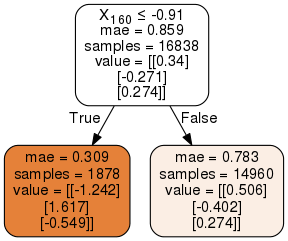

In [32]:
dot_data = StringIO()
export_graphviz(stump, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph .set_size('"3,3!"')
Image(graph.create_png())

In [33]:
#predict val
y_pred_val = stump.predict(x_val)

mae_stump_val= mean_absolute_error(scaler_y.inverse_transform(y_val),scaler_y.inverse_transform(y_pred_val))
print("Mean Absolute Error (Validation): ", mae_stump_val)

Mean Absolute Error (Validation):  43.506267083896255


In [34]:
#predict train
y_pred_tr = stump.predict(x_tr)
mae_stump_tr= mean_absolute_error(scaler_y.inverse_transform(y_tr), scaler_y.inverse_transform(y_pred_tr))
print("Mean Absolute Error (Train): ", mae_stump_tr)

Mean Absolute Error (Train):  43.666256968987305


In [35]:
mae_all["stump_tr"]  = mae_stump_tr
mae_all["stump_val"] = mae_stump_val

In [36]:
score_tr_stump= stump.score(x_tr, y_tr)
score_val_stump = stump.score(x_val, y_val)
print("Score train     : ", score_tr_stump)
print("Score validation: ", score_val_stump)

score_all["stump_tr"]  = score_tr_stump
score_all["stump_val"] = score_val_stump

Score train     :  0.10733769269135178
Score validation:  0.11150849386741511


In [37]:
def graph_bar(data_x, data_y, label_x, label_y, title):
    sns.set(style="whitegrid")
    sns.barplot(x=list(data_x), y=list(data_y))
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)

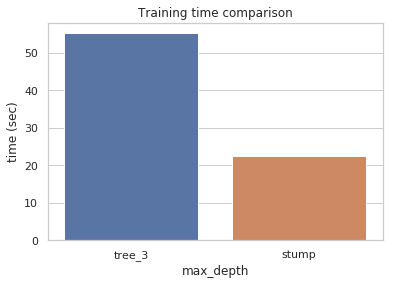

In [38]:
keys=time_all.keys()
values=time_all.values()
graph_bar(keys, values, "max_depth", "time (sec)", "Training time comparison")

**Comentario**: 

>¿Cómo cambia el error (MAE) en entrenamiento y validación con respecto al árbol de la pregunta anterior? 

El error MAE como se puede observar en los siguientes graficos empeora casi 15 puntos, pero el modelo claramente es mas sencillo (y por ende, menos tiempo entrenamiento). Es dificil que un modelo tan simple pueda generar predicciones correctas a no ser que tenga caracteristica altamente descriptivas. 

>Discuta sobre el numero de parámetros entrenables que tendrá cada modelo.

Para un modelo arbol de decisión, si nosotros tuneamos la cantidad de profundidad con la cual nosotros vamos a construir dichos regresores, vamos a tener $2^{profundidad} - 1$ parametros a entrenar.

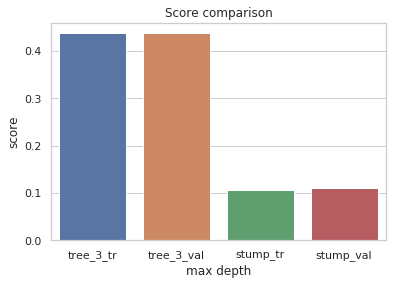

In [46]:
score_all.pop('lr_tr', None)
score_all.pop('kr_val', None)
keys=score_all.keys()
values=score_all.values()
graph_bar(keys, values, "max depth", "score", "Score comparison", )

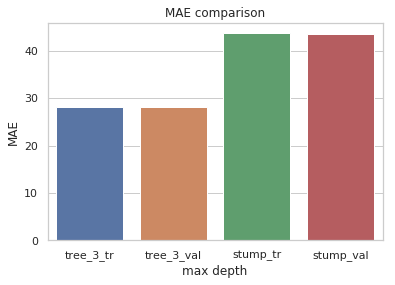

In [47]:
mae_all.pop('lr_tr', None)
mae_all.pop('lr_val', None)
keys=mae_all.keys()
values=mae_all.values()
graph_bar(keys, values, "max depth", "MAE", "MAE comparison")

#### 1.e Profundidad máxima
>Explore distintos valores de la profundidad máxima del árbol. Para esto, realice K-fold sobre al menos 10 valores distintos de la profundidad del árbol y compare el promedio de los MAE de validación. También guarde los promedios de MAE de _train_ y grafique como estos varían a medida varia la profundidad máxima. Idealmente debería considerar un rango entre profundidad máxima 1 y 20. Note que este paso puede resultar largo en tiempo de cómputo, podría ser recomendable correrlo en _Collab_ en caso de tener máquinas más lentas. 

>Finalmente, entrene el arbol con profundidad óptima sobre todos los datos de entrenamiento y calcule su MAE sobre validación. ¿Mejoramos el desempeño obtenido anteriormente con los árboles sin sintonizar? 

In [50]:
#Validación cruzada,  kFold=5
results = []
results_prom_mae_tr = []
results_prom_mae_val = []
depth = np.arange(2,32,2) # al menos profundidad del árbol, 10 valores
for d in depth:
    folds_mae_tr = []
    folds_mae_val = []
    kf = KFold(n_splits=5,shuffle=True)
    print(d)
    i = 0
    for train_index, val_index in kf.split(x_tr):
        print("Fold: ", i)
        i=i+1
        tree =  DecisionTreeRegressor(criterion='mae',max_depth=d, random_state=42)
        start_time = time.time()
        tree.fit(x_tr[train_index], y_tr[train_index])
        end_time = time.time()
        total_time = end_time-start_time
        
        y_pred_val = tree.predict(x_tr[val_index])
        y_pred_tr = tree.predict(x_tr[train_index])
        
        score_tr = tree.score(x_tr[train_index], y_tr[train_index])
        score_val= tree.score(x_tr[val_index], y_tr[val_index])#r2_score(y_tr[val_index], y_pred_val)
        
        mae_val = mean_absolute_error(scaler_y.inverse_transform(y_tr[val_index]), scaler_y.inverse_transform(y_pred_val))
        mae_tr = mean_absolute_error(scaler_y.inverse_transform(y_tr[train_index]), scaler_y.inverse_transform(y_pred_tr))
        
        folds_mae_tr.append(mae_tr)
        folds_mae_val.append(mae_val)    
        
        results.append({'depth':d,'score_tr': score_tr, 'score_val':score_val,  'mae_tr': mae_tr, 'mae_val': mae_val, 'time_':total_time})
    results_prom_mae_tr.append({'depth': d, 'mae_mean':np.mean(folds_mae_tr)})
    results_prom_mae_val.append({'depth': d, 'mae_mean':np.mean(folds_mae_val)})
    
results = pd.DataFrame(results)  
prom_mae_tr = pd.DataFrame(results_prom_mae_tr)
prom_mae_val  = pd.DataFrame(results_prom_mae_val)

2
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
4
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
6
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
8
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
10
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
12
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
14
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
16
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
18
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
20
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
22
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
24
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
26
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
28
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
30
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4


In [51]:
results.head(5)

,depth,mae_tr,mae_val,score_tr,score_val,time_
0,2,31.532040,30.938638,0.317663,0.321130,26.053663
1,2,31.283512,31.702292,0.321126,0.310871,25.948230
2,2,31.292436,31.666631,0.319912,0.315948,25.815278
3,2,31.112947,32.418578,0.321799,0.298240,25.879461
4,2,31.487415,30.922184,0.314723,0.329839,25.826046


In [52]:
export_csv = results.to_csv (r'/home/eprovidel/ML/Tarea 3/parte1/results.csv', index = None, header=True)


In [53]:
prom_mae_tr.head(5)

,depth,mae_mean
0,2,31.341670
1,4,24.444100
2,6,18.127338
3,8,14.038054
4,10,10.690266


In [54]:
prom_mae_val.head(5)

,depth,mae_mean
0,2,31.529665
1,4,24.553768
2,6,18.246656
3,8,14.427179
4,10,11.348425


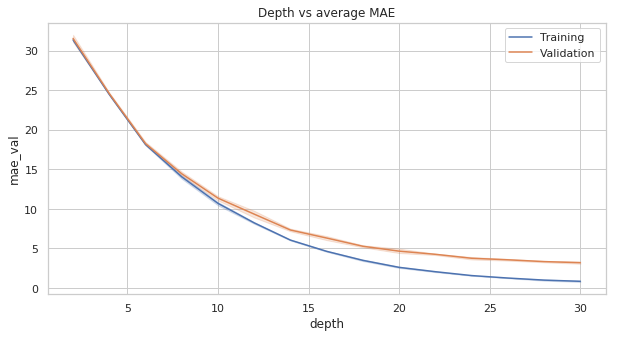

In [55]:
plt.figure(figsize=(10,5))
plt.title("Depth vs average MAE")
ax = sns.lineplot('depth','mae_tr',data=results) #Tiene que ser el dataset results y la columna mae (en vez de mae_mean)
ax = sns.lineplot('depth','mae_val',data=results,ax=ax) #Tiene que ser el dataset results y la columna mae (en vez de mae_mean)
ax.legend(['Training','Validation'])
plt.show()    
    

#### Árbol con el mejor resultado de MAE y todos los datos 

In [56]:
best = prom_mae_val.sort_values(['mae_mean'],ascending=True).iloc[0]
print("Best depth: ", best)

Best depth:  depth       30.000000
mae_mean     3.195989
Name: 14, dtype: float64


In [57]:
tree_best =  DecisionTreeRegressor(criterion='mae',max_depth=int(best[0]), random_state=7)
start_time = time.time()
tree_best.fit(x_tr, y_tr)
end_time = time.time()
total_time = end_time-start_time
        
y_pred_val = tree_best.predict(x_val)
y_pred_tr = tree_best.predict(x_tr)
        
score_tr = tree_best.score(x_tr, y_tr)
score_val= tree_best.score(x_val, y_val)#r2_score(y_tr[val_index], y_pred_val)
        
mae_val = mean_absolute_error(scaler_y.inverse_transform(y_val), scaler_y.inverse_transform(y_pred_val))
mae_tr = mean_absolute_error(scaler_y.inverse_transform(y_tr), scaler_y.inverse_transform(y_pred_tr))

>Finalmente, entrene el arbol con profundidad óptima sobre todos los datos de entrenamiento y calcule su MAE sobre validación. ¿Mejoramos el desempeño obtenido anteriormente con los árboles sin sintonizar? 

Originalmente, el arbol sin sintonizar y con profundidad 3 obtiene un mae de validacion de: 28.0511. Mientras que como a continuación se muestra, un arbol con los parametros de pronfundad sintonizados, se puede observar que tiene un mae de 4.3513. 

A continuación se presentaran los resultados obtenidos para este arbol tuneado y los resultados de la validación cruzada con respecto a la profundidad:

In [71]:
print("Mae de validacion: \t{}".format(mae_val))
print("Mae de training: \t{}".format(mae_tr))
print("Mejor mae val. cruzada:\t{}".format(best[1]))

Mae de validacion: 	4.351336040498634
Mae de training: 	0.9113893286035739
Mejor mae val. cruzada:	3.1959886060113893


#### Comparación con MAE en kfolds

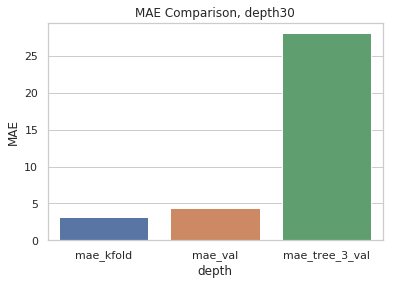

In [73]:
graph_bar(['mae_kfold', 'mae_val ','mae_tree_3_val'], [best[1],mae_val,mae_all['tree_3_val']], "depth", "MAE", "MAE Comparison, depth"+str(int(best[0])))

In [ ]:
dot_data = StringIO()
export_graphviz(tree_best, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph .set_size('"10,10!"')
graph.write_png("dtree.png")
#Image(graph.create_png())

#### 1.f Random Forest

>En la pregunta anterior vimos que una profundidad de árbol muy grande puede llevarnos a _overffiting_, pues la cantidad de "decisiones" que puede aprender el modelo aumentan significativamente y el modelo tenderá a aprender de memoria el conjunto de entrenamiento, perdiendo capacidad de generalización. Otra aproximación para evitar _overffiting_ no utilizar todos los datos para entrenar, estrategia implementada por _Random Forest_. 

>Discuta por qué el utilizar muchos modelos que no conocen todos los datos puede ayudar a mejorar la capacidad de generalización, evitando así que el modelo final este sobreajustado. Entrene luego un _Random Forest Regressor_, con a lo menos 10 árboles. Discuta sobre que elección realizar sobre la profundidad máxima de estos árboles. ¿Cómo se compara el desempeño de _Random Forest_ frente a un árbol por si solo?

> Discuta por qué el utilizar muchos modelos que no conocen todos los datos puede ayudar a mejorar la capacidad de generalización, evitando así que el modelo final este sobreajustado. 

**Comentario:** Aqui enfrentamos el problema del tradeoff entre sesgo (bias) y varianza. Un modelo complejo tiene bajo sesgo, pero alta varianza; mientras que un modelo simple tiene una baja varianza, pero alto sesgo. Como se entrenan los random forests, sabemos que, estos utilizan sub conjuntos de variables aleatorias del conjunto de datos original. Por lo que cada uno de estos arboles puede especializarse en una parte del conjunto,  y esperando que haya una suficiente diversidad en los subconjuntos para entrenar, generar modelos que esten mas especializados y puedan aportar mas al proceso de votación final para la regresión (o clasificación dependiendo del problema). El sobreajuste puede darse, pero en ciertos arboles del random forest, los cuales pueden ser mitigados por la votación de los otros arboles que no estan sobreajustados (de nuevo, si es que hay suficiente diversidad en los conjuntos generados).



In [48]:
depth

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [49]:
results_RFG = []

for n in np.arange(10,21, 5):
    print("***n:  ",n," ****" )
    for d in depth:
        print("d: ", d)
        forest = RandomForestRegressor(n_estimators=n, #The number of trees in the forest.
                               criterion='mae',
                               max_depth=d, random_state=42)
        start_time = time.time()
        forest.fit(x_tr, y_tr)
        end_time = time.time()
        total_time = end_time-start_time
            
        y_pred_val = forest.predict(x_val)
        y_pred_tr = forest.predict(x_tr)
        
        score_tr= forest.score(x_tr, y_tr)
        score_val= forest.score(x_val, y_val)
        
        mae_val = mean_absolute_error(scaler_y.inverse_transform(y_val), scaler_y.inverse_transform(y_pred_val))
        mae_tr = mean_absolute_error(scaler_y.inverse_transform(y_tr), scaler_y.inverse_transform(y_pred_tr))
        results_RFG.append({'n_estimators':n,'depth':d,'score_tr': score_tr, 'score_val':score_val,  'mae_tr': mae_tr, 'mae_val': mae_val, 'time_':total_time})

***n:   10  ****
d:  2
d:  4
d:  6
d:  8
d:  10
d:  12
d:  14
d:  16
d:  18
d:  20
d:  22
d:  24
d:  26
d:  28
d:  30
***n:   15  ****
d:  2
d:  4
d:  6
d:  8
d:  10
d:  12
d:  14
d:  16
d:  18
d:  20
d:  22
d:  24
d:  26
d:  28
d:  30
***n:   20  ****
d:  2
d:  4
d:  6
d:  8
d:  10
d:  12
d:  14
d:  16
d:  18
d:  20
d:  22
d:  24
d:  26
d:  28
d:  30


In [50]:
results_RFG = pd.DataFrame(results_RFG) 
results_RFG.head(10)

,depth,mae_tr,mae_val,n_estimators,score_tr,score_val,time_
0,2,31.270818,31.403327,10,0.338840,0.337592,183.320366
1,4,23.902879,23.928591,10,0.601539,0.594987,285.626655
2,6,17.475083,17.621129,10,0.738977,0.735230,326.097808
3,8,13.996041,14.471458,10,0.814882,0.805318,357.313145
4,10,11.016759,11.647481,10,0.860886,0.850960,373.240100
5,12,9.649778,10.404251,10,0.890280,0.880982,387.862130
6,14,7.769498,8.669933,10,0.922166,0.912447,394.091791
7,16,6.796114,7.776988,10,0.933895,0.924449,399.196603
8,18,5.890048,7.026155,10,0.951848,0.941458,399.735967
9,20,5.746239,6.893737,10,0.956708,0.946554,397.477249


In [89]:
results_RFG.shape

(45, 7)

In [90]:
export_csv = results_RFG.to_csv (r'/home/eprovidel/ML/Tarea 3/parte1/results_RFG.csv', index = None, header=True)

In [75]:
results_RFG = pd.read_csv('/home/eprovidel/ML/Tarea 3/parte1/results_RFG.csv')
results_RFG

,depth,mae_tr,mae_val,n_estimators,score_tr,score_val,time_
0,2,31.270818,31.403327,10,0.338840,0.337592,183.320366
1,4,23.902879,23.928591,10,0.601539,0.594987,285.626655
2,6,17.475083,17.621129,10,0.738977,0.735230,326.097808
3,8,13.996041,14.471458,10,0.814882,0.805318,357.313145
4,10,11.016759,11.647481,10,0.860886,0.850960,373.240100
5,12,9.649778,10.404251,10,0.890280,0.880982,387.862130
6,14,7.769498,8.669933,10,0.922166,0.912447,394.091791
7,16,6.796114,7.776988,10,0.933895,0.924449,399.196603
8,18,5.890048,7.026155,10,0.951848,0.941458,399.735967
9,20,5.746239,6.893737,10,0.956708,0.946554,397.477249


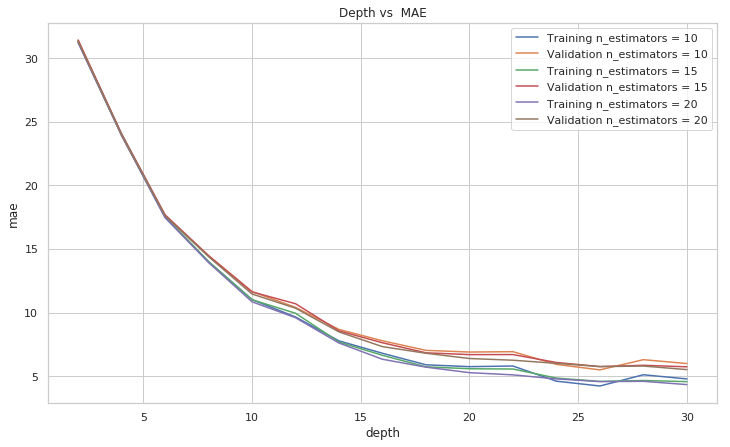

In [86]:
mask_1 = results_RFG['n_estimators'] == 10
mask_2 = results_RFG['n_estimators'] == 15
mask_3 = results_RFG['n_estimators'] == 20

plt.figure(figsize=(12,7))
plt.title("Depth vs  MAE")
ax = sns.lineplot('depth','mae_tr',data=results_RFG[mask_1])
ax = sns.lineplot('depth','mae_val',data=results_RFG[mask_1],ax=ax)

ax = sns.lineplot('depth','mae_tr',data=results_RFG[mask_2])
ax = sns.lineplot('depth','mae_val',data=results_RFG[mask_2],ax=ax)

ax = sns.lineplot('depth','mae_tr',data=results_RFG[mask_3])
ax = sns.lineplot('depth','mae_val',data=results_RFG[mask_3],ax=ax)
ax.legend(['Training n_estimators = 10',
           'Validation n_estimators = 10',
           'Training n_estimators = 15',
           'Validation n_estimators = 15',
           'Training n_estimators = 20',
           'Validation n_estimators = 20'])
plt.ylabel("mae")
plt.show()    

In [88]:
best_rf = results_RFG.sort_values(['mae_val'], ascending=True).iloc[0]
best_rf

depth            26.000000
mae_tr            4.224364
mae_val           5.491924
n_estimators     10.000000
score_tr          0.973204
score_val         0.963480
time_           402.259517
Name: 12, dtype: float64

>Discuta sobre que elección realizar sobre la profundidad máxima de estos árboles. 

Nosotros fuimos probando para distintas cantidades de numero de arboles dentro del random forest, distintos valores de profundidad (desde 2 hasta 30). Uno esperaria que a mayor cantidad de profundidad de arbol, este funcionara mejor en el random forest, debido a que los arboles van a ser mas complejos. Resulta que si bien nuestro mejor mae fue con 10 estimadores y 26 de profundidad, uno puede notar que camino hacia la profundidad 30 hay una tendencia a la baja del mae. 

>¿Cómo se compara el desempeño de Random Forest frente a un árbol por si solo?

En este caso, Random Forest no funciona mejor que el arbol sintonizado respecto a su profundidad (Arbol con una profundidad maxima de 30). Obteniendo un mae de 5.4919 (Random Forest) vs un mae de 4.3513 (Arbol de profundidad 30). A continuación se presenta la comparación con tres modelos: Mejor Random Forest, Arbol con profundidad 30 y Arbol con profundidad 3.

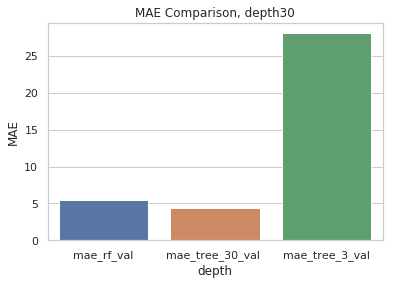

In [91]:
graph_bar(['mae_rf_val','mae_tree_30_val ','mae_tree_3_val'], [best_rf['mae_val'],mae_val,mae_all['tree_3_val']], "depth", "MAE", "MAE Comparison, depth"+str(int(best[0])))

In [97]:
forest = RandomForestRegressor(n_estimators=100, #The number of trees in the forest.
                               criterion='mae',
                               max_depth=26, random_state=42, n_jobs=-1)
start_time = time.time()
forest.fit(x_tr, y_tr)
end_time = time.time()
total_time = end_time-start_time

y_pred_val = forest.predict(x_val)
y_pred_tr = forest.predict(x_tr)

score_tr= forest.score(x_tr, y_tr)
score_val= forest.score(x_val, y_val)

mae_val = mean_absolute_error(scaler_y.inverse_transform(y_val), scaler_y.inverse_transform(y_pred_val))
mae_tr = mean_absolute_error(scaler_y.inverse_transform(y_tr), scaler_y.inverse_transform(y_pred_tr))

In [98]:
print(mae_val,mae_tr)

5.75571780716498 4.686577817321119


#### 1.g Otros parámetros

>Por último, investigue un poco sobre los otros parámetros de los árboles y sus implicancias. Luego, entrene un arbol modificando algunos de sus parámetros de una forma que piensen podría haber mejorado el desempeño. Discuta

##### Parámetros -- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- `criterion`= mse/friedman_mse/mae $\rightarrow$ minimiza la pérdida de L1 utilizando la mediana de cada nodo terminal
- `splitter`= best/random  $\rightarrow$  indica la estrategia que se utilizará para elegir la división en cada nodo. Puede ser al azar o las mejores.
- `max_depth` $\rightarrow$ indica la máxima profundidad del árbol, si no se especifica los nodos se expanden lo máximo que se pueda hasta encontrar hojas "puras" o hasta que contengan menos muestras (`min_samples_split`)
- `min_samples_split` $\rightarrow$  parámetro que indica el número de muestras mínimo que se necesitan para dividir un nodo.
- `min_samples_leaf` $\rightarrow$ establece cuál es el número mínimo de muestras que deben estar en cada nodo hoja, tanto para la rama izquierda como derecha. Puede tener el efecto de suavizar el modelo, sobre todo el regresión.
- `min_weight_fraction_leaf` $\rightarrow$ esta asociado a la ponderación de los nodos hojas. El parámetro requiere que la fracción ponderada mínima, de la suma total de pesos (de todas las muestras de entrada) sea un nodo hoja. Las muestras tienen el mismo peso cuando no se proporciona sample_weight.
- `max_features` $\rightarrow$  indica el número de características a considerar cuando se busca la mejor división. Algunas opciones: “auto”: max_features=n_features. “sqrt”: max_features=sqrt(n_features). “log2“: max_features=log2(n_features). None: max_features=n_features.
- `random_state` $\rightarrow$ semilla utilizada para el generador de número aleatorios.
- `max_leaf_nodes` $\rightarrow$ crea un árbol con la cantidad de hojas indica de la mejor manera.
- `min_impurity_decrease` $\rightarrow$ Indica si un nodo se podrá o no dividir en base a "impureza". Si la división lleva a una disminución de la "impureza" mayor o igual al valor del parámetro.

$$N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)$$

Donde:
`N`: número total de muestras.
`N_t`: número de muestras del nodo actual.
`N_t_L`: número de muestras en el nodo izquierdo.
`N_t_R`: número de muestras en el nodo derecho.

- `min_impurity_split ` $\rightarrow$   Umbral que permite  parar de forma anticipada el crecimiento de un árbol. Uno nodo se dividira si la impureza esta por sobre el úmbra, del contrario es una hoja.
- `presort` $\rightarrow$  indica si se debe presort los datos para acelerar la búsqueda. Cuando son muchos datos esto puede relentizar el entrenamiento y acelerar para conju<ntos de datos pequeños.


In [53]:
#criterion, splitter, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf,
#max_features, random_state, max_leaf_nodes, min_impurity_decrease

#Parametros no considerados: min_samples_split default=2, min_weight_fraction_leaf, max_features, max_leaf_nodes

results_g = []
for min_leaf in [4,8,16,24,32,64,128,256]:
    for min_impurity in [0.0005,0.001, 0.005,0.01,0.05,0.01,0.5]:
        for min_split in [0.01,0.03 ,0.05, 0.07, 0.09, 0.1]:
            tree_g = DecisionTreeRegressor(criterion='mae',
                            splitter = 'best', 
                            max_depth=int(best[0]), #colocar acá el mejor anterior obtenido
                            min_samples_leaf = min_leaf,   
                            min_impurity_decrease=min_impurity, #0.1, # for instance
                            min_samples_split=int(x_tr.shape[0]*min_split), #for instance
                            random_state = 42, 
                            presort = 'auto'   
                            )
            start_time   = time.time()
            tree_g.fit(x_tr, y_tr)
            end_time     = time.time()
            total_time_g = end_time-start_time
        
            y_pred_val_g = tree_g.predict(x_val)
            y_pred_tr_g  = tree_g.predict(x_tr)
        
            score_tr_g   = tree_g.score(x_tr, y_tr)
            score_val_g  = tree_g.score(x_val, y_val)#r2_score(y_tr[val_index], y_pred_val)
        
            mae_val_g    = mean_absolute_error(scaler_y.inverse_transform(y_val), scaler_y.inverse_transform(y_pred_val_g))
            mae_tr_g     = mean_absolute_error(scaler_y.inverse_transform(y_tr), scaler_y.inverse_transform(y_pred_tr_g))

            results_g.append({'min_leaf':min_leaf, 'min_impurity':min_impurity,'min_split':min_split, 
                              'time': total_time_g, 'score_tr':score_tr_g, 'score_val':score_val_g,'mae_val':mae_val_g, 'mae_tr':mae_tr_g })

In [ ]:
results_g = pd.DataFrame(results_g)
results_g

,mae_tr,mae_val,min_impurity,min_leaf,min_split,score_tr,score_val,time
0,7.446409,7.891164,0.0005,4,0.01,0.916051,0.907077,97.097916
1,8.595148,8.880555,0.0005,4,0.03,0.878223,0.874306,95.685761
2,9.890512,10.312595,0.0005,4,0.05,0.843925,0.839005,95.468538
3,10.932408,11.272573,0.0005,4,0.07,0.819260,0.817306,94.112209
4,12.125607,12.392828,0.0005,4,0.09,0.790712,0.791456,93.426619
5,12.125607,12.392828,0.0005,4,0.10,0.790712,0.791456,93.038236
6,8.684142,9.061615,0.0010,4,0.01,0.886627,0.879707,96.181107
7,8.867305,9.250547,0.0010,4,0.03,0.874771,0.868833,95.528672
8,9.890512,10.312595,0.0010,4,0.05,0.843925,0.839005,94.702664
9,10.932408,11.272573,0.0010,4,0.07,0.819260,0.817306,94.428890


In [100]:
results_g = pd.read_csv('/home/eprovidel/ML/Tarea 3/parte1/results_g.csv')
results_g.head()

,mae_tr,mae_val,min_impurity,min_leaf,min_split,score_tr,score_val,time
0,7.446409,7.891164,0.0005,4,0.01,0.916051,0.907077,97.097916
1,8.595148,8.880555,0.0005,4,0.03,0.878223,0.874306,95.685761
2,9.890512,10.312595,0.0005,4,0.05,0.843925,0.839005,95.468538
3,10.932408,11.272573,0.0005,4,0.07,0.819260,0.817306,94.112209
4,12.125607,12.392828,0.0005,4,0.09,0.790712,0.791456,93.426619


In [101]:
results_g.sort_values(['mae_val'], ascending=True).iloc[0:10]

,mae_tr,mae_val,min_impurity,min_leaf,min_split,score_tr,score_val,time
0,7.446409,7.891164,0.0005,4,0.01,0.916051,0.907077,97.097916
42,7.446409,7.891164,0.0005,8,0.01,0.916051,0.907077,96.378936
84,7.451296,8.042033,0.0005,16,0.01,0.913848,0.901338,94.411585
126,7.540939,8.112034,0.0005,24,0.01,0.913240,0.901656,92.551487
168,7.802421,8.326611,0.0005,32,0.01,0.912495,0.902208,90.857842
1,8.595148,8.880555,0.0005,4,0.03,0.878223,0.874306,95.685761
43,8.595148,8.880555,0.0005,8,0.03,0.878223,0.874306,94.772236
210,8.384973,8.935853,0.0005,64,0.01,0.892017,0.882912,86.615829
85,8.587204,9.010503,0.0005,16,0.03,0.877081,0.870649,93.300862
90,8.684142,9.061615,0.0010,16,0.01,0.886627,0.879707,94.117065


**Comentarios:** De lo que podemos observar del top 10 de los mejores mae de validación, corresponde a que encontramos como factor comun el paramentro de `min_impurity_decrease` seguido por el parametro `min_samples_split`.

Respecto a `min_impurity_decrease`, este parametro modela un umbral el cual nos permite aceptar un split dada si la impureza de dicho split esta por sobre este umbral. Esto significa que genera arboles mas especificos a medida que `min_impurity_decrease` sea cercano (o igual) a cero. revisando el mae de entrenamiento, podemos ver que cercano a el mae de validación, por lo que podemos sospechar que este modelo no esta sobreajustando, considerando que los split deberian generar arboles mas complejos.